## Analyzing Entropy for a Random Circuit
Considering circuits different number of Qubits and varying Depths

**1) Configure Qiskit Runtime Service, and Input Parameters**
<br/>
Input Parameters:
- Range for number of qubits
- Circuit depth range
- Number of circuit runs

In [18]:
from qiskit_ibm_runtime import QiskitRuntimeService
from config import api_key
import numpy as np

# # Save an IBM Quantum account as your default account, and Load saved credentials
# QiskitRuntimeService.save_account(
#     channel="ibm_quantum", token=api_key, set_as_default=True, overwrite=True
# )
# service = QiskitRuntimeService()

# Define Input Parameters
num_q = np.arange(2, 6, 1)
depths = np.arange(3, 21, 1)
runs = 100

**2) Generate Random Circuits and Compute Entropy**

In [19]:
from qiskit.providers.basic_provider import BasicSimulator
import pandas as pd
from random_circuit import eagle_gate_set, basis_gate_set
from random_circuit import get_random_circuit
from entropy import get_average_entropy

# Define backend to run jobs
backend = BasicSimulator()
# backend = service.backend("ibmq_qasm_simulator")

# Choose a set of gates to build circuit
gate_set = basis_gate_set

# Calculate entropy - Looping over depth and number of qubits
data_list = []
for n in num_q:
    for d in depths:
        circuit = get_random_circuit(n, d, gate_set)
        entropy = get_average_entropy(circuit, runs, backend)
        data_list.append({"Num": n, "depth": d, "entropy": entropy, "circuit": circuit})
data = pd.DataFrame(data_list)

# Print the DataFrame
print(data)

    Num  depth   entropy                                            circuit
0     2      3  0.124876  ((Instruction(name='z', num_qubits=1, num_clbi...
1     2      4  0.130876  ((Instruction(name='x', num_qubits=1, num_clbi...
2     2      5  0.130880  ((Instruction(name='swap', num_qubits=2, num_c...
3     2      6  0.124893  ((Instruction(name='cx', num_qubits=2, num_clb...
4     2      7  0.139862  ((Instruction(name='cx', num_qubits=2, num_clb...
..  ...    ...       ...                                                ...
67    5     16  0.324237  ((Instruction(name='id', num_qubits=1, num_clb...
68    5     17  0.340096  ((Instruction(name='z', num_qubits=1, num_clbi...
69    5     18  0.340138  ((Instruction(name='id', num_qubits=1, num_clb...
70    5     19  0.329105  ((Instruction(name='swap', num_qubits=2, num_c...
71    5     20  0.326238  ((Instruction(name='id', num_qubits=1, num_clb...

[72 rows x 4 columns]


**3) Plot Entropy vs Depth for different Number of Qubits**

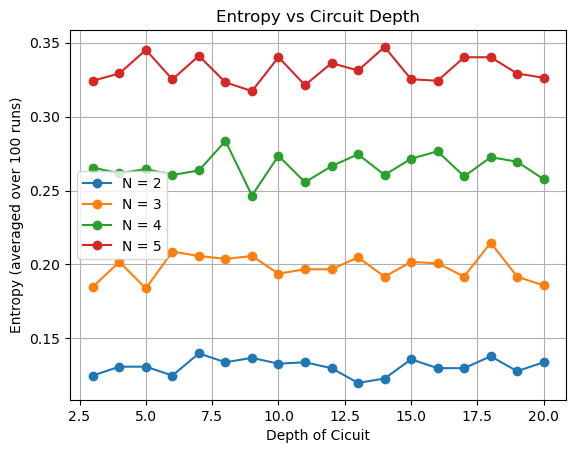

In [23]:
import matplotlib.pyplot as plt

# Plotting
plt.title("Entropy vs Circuit Depth")
plt.xlabel("Depth of Cicuit")
plt.ylabel("Entropy (averaged over " + str(runs) + " runs)")

for N in num_q:
    filtered_df = data[data["Num"] == N]
    lbl = "N = " + str(N)
    plt.plot(filtered_df["depth"], filtered_df["entropy"], marker='o', label=lbl)

plt.grid(True)
plt.legend()
plt.show()

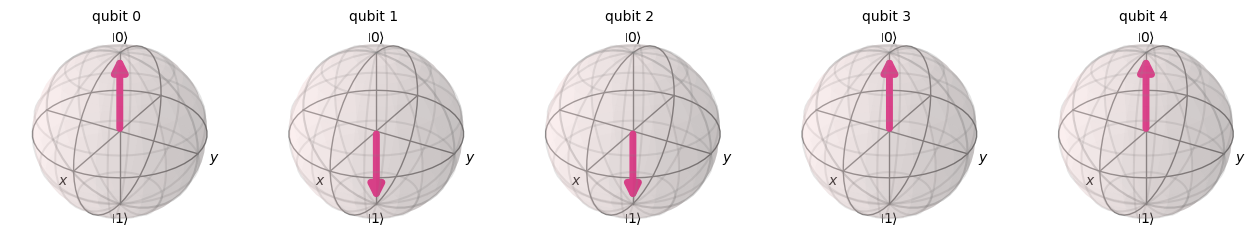

In [6]:
from qiskit.quantum_info import DensityMatrix, Statevector, entropy
from qiskit.visualization import plot_bloch_multivector

# Simulate the state vector
state_vector = Statevector(circuit)
density_matrix = DensityMatrix.from_instruction(circuit)

# plot_bloch_multivector(state_vector)
plot_bloch_multivector(density_matrix)